# House Prices - Advanced Regression Techniques

## Preprocessing

### Basic Setup

#### Importing necessary modules

In [1]:
#Importing Modules
import sklearn
import scipy
import scipy.stats as stats
from scipy.stats import boxcox_normmax, zscore
from scipy.special import boxcox1p
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error 
from sklearn.model_selection import KFold, RandomizedSearchCV
from mlxtend.regressor import StackingCVRegressor
from multiprocessing import cpu_count
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

#### Importing training and testing data

In [2]:
train_data = pd.read_csv("E:\Education\Kaggle Projects\House Price - Advanced Regression\Kaggle-House-Price-Prediction\Data/train.csv",index_col="Id")
test_data  = pd.read_csv("E:\Education\Kaggle Projects\House Price - Advanced Regression\Kaggle-House-Price-Prediction\Data/test.csv",index_col="Id")
old_prediction = pd.read_csv("E:\Education\Kaggle Projects\House Price - Advanced Regression\Kaggle-House-Price-Prediction\Data\oldprediction.csv")

### Data Visualization

#### Scatter Plot to check for Raw Outliers

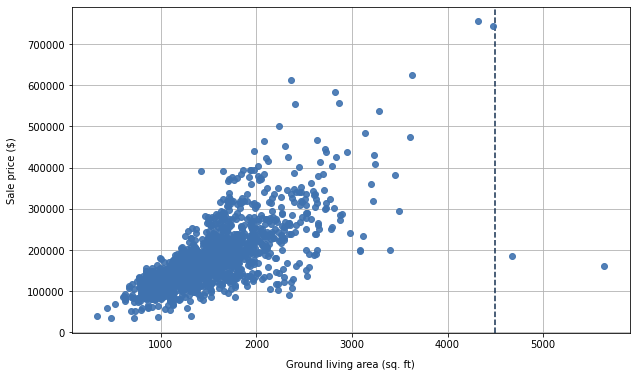

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.scatter(train_data["GrLivArea"], train_data["SalePrice"], c="#3f72af", zorder=3, alpha=0.9)
ax.axvline(4500, c="#112d4e", ls="--", zorder=2)
ax.set_xlabel("Ground living area (sq. ft)", labelpad=10)
ax.set_ylabel("Sale price ($)", labelpad=10)
plt.show()

#### Removing Outliers identified from above graph & merging train and test data

In [4]:
train_data = train_data[train_data["GrLivArea"]<4450]
#merging train and test data
data = pd.concat([train_data.drop("SalePrice",axis=1),test_data])

In [5]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


#### Bar Graph to check number of missing values

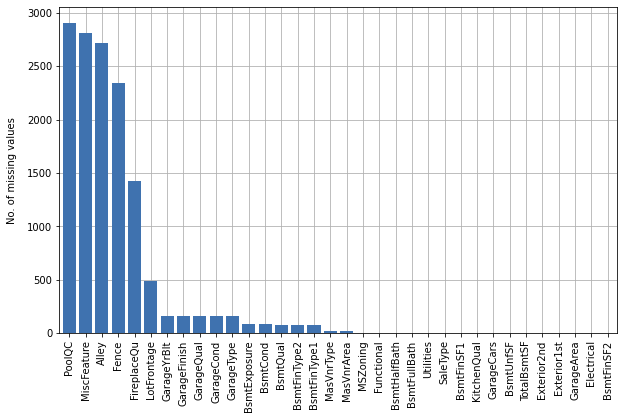

In [6]:
nans = data.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

#### Numerical Variables

#### Discrete Values

In [15]:
numerical_features=[]
for feature in train_data:
    if train_data[feature].dtype!='O' and feature!= 'SalePrice':
        numerical_features.append(feature)

discrete_variables=[]
for feature in numerical_features:
    if len(train_data[feature].unique())<=25 and feature != 'SalePrice':
        discrete_variables.append(feature)

print(discrete_variables)

['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


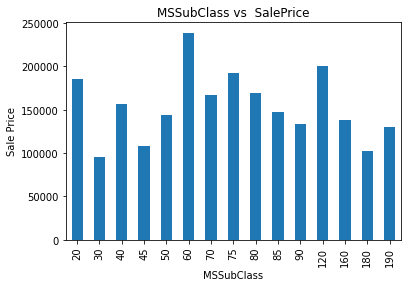

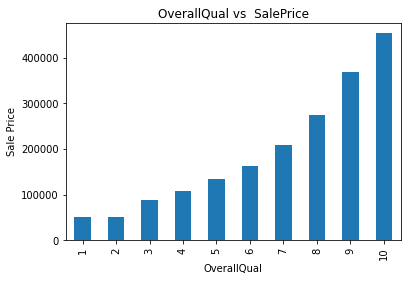

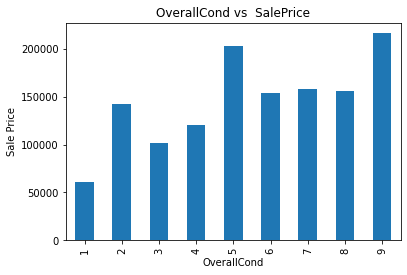

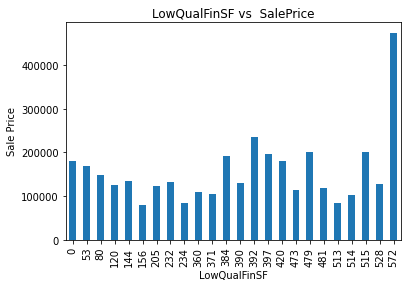

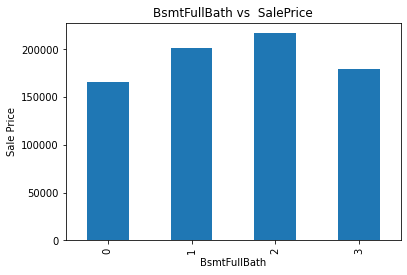

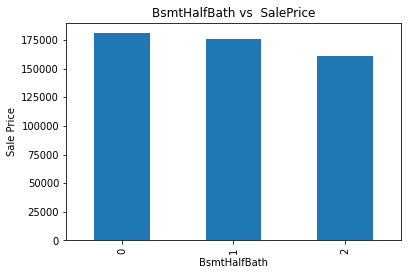

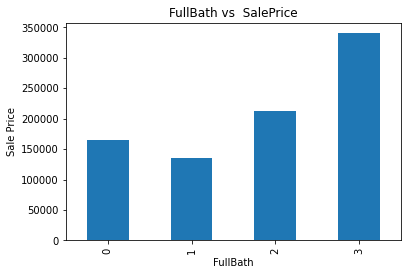

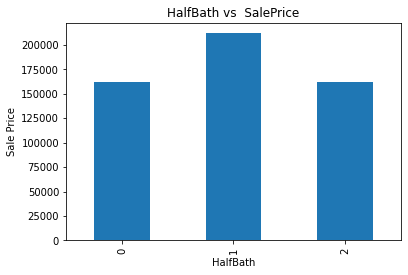

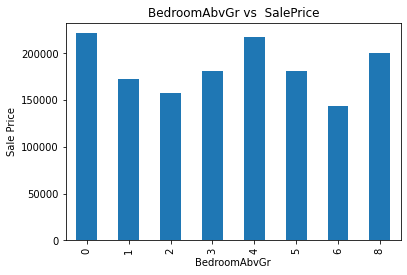

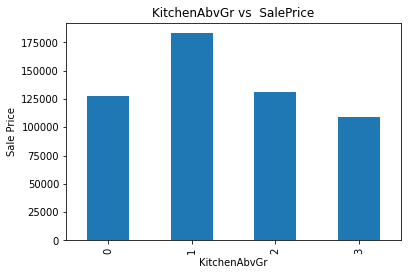

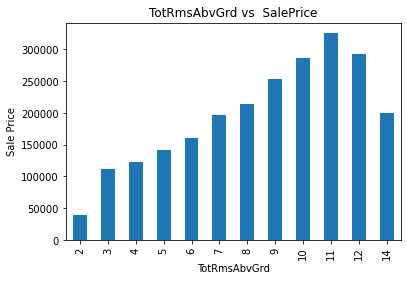

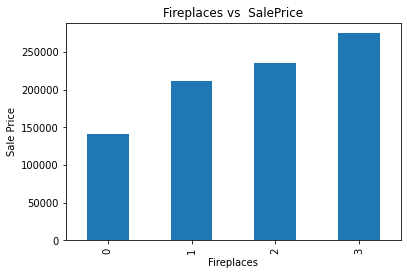

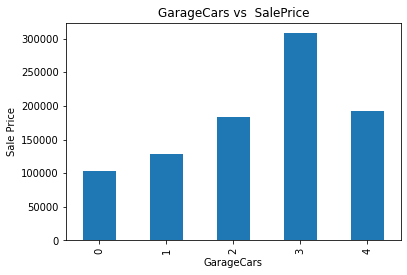

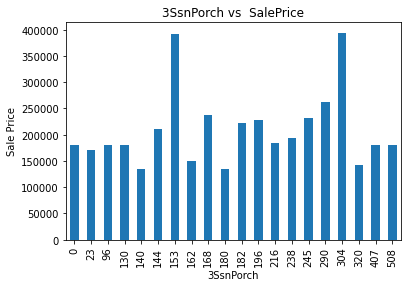

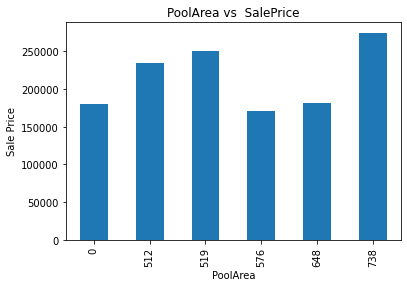

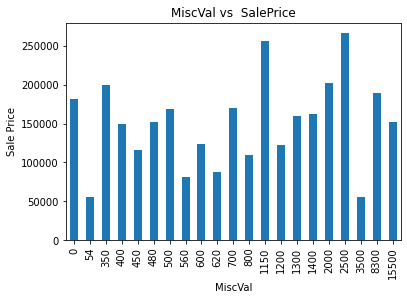

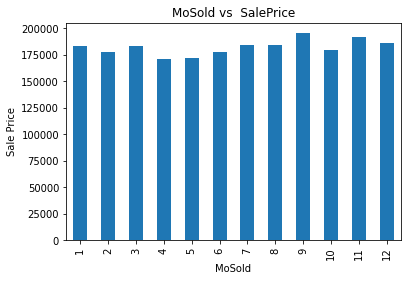

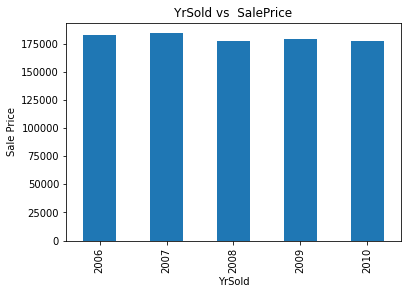

In [16]:
for feature in discrete_variables:
     train_data.groupby(feature)['SalePrice'].mean().plot.bar()
     plt.xlabel(feature)
     plt.ylabel('Sale Price')
     plt.title(feature +' vs '+' SalePrice')
     plt.show()

#### Continuous Values

In [21]:
continuous_variables=[]
for feature in numerical_features:
    if feature not in discrete_variables and feature not in ["YearBuilt","YearRemodAdd","GarageYrBlt","YrSold"]:
        continuous_variables.append(feature)

print(continuous_variables)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch']


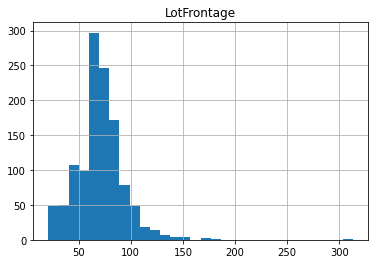

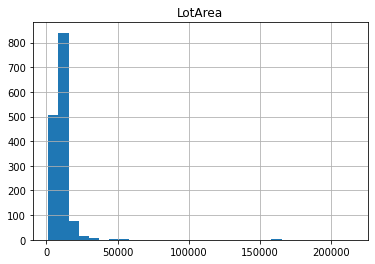

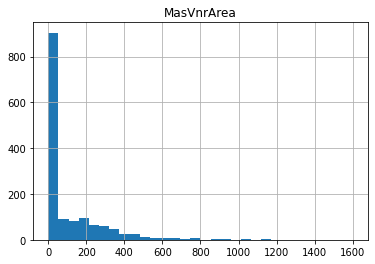

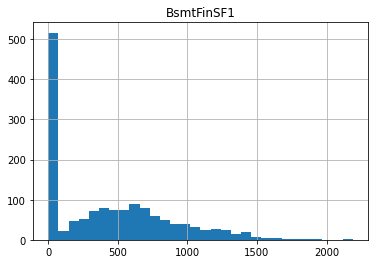

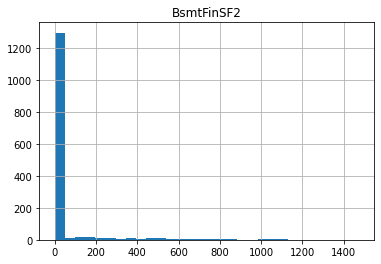

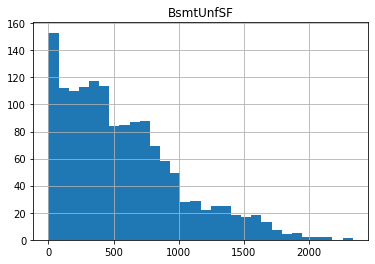

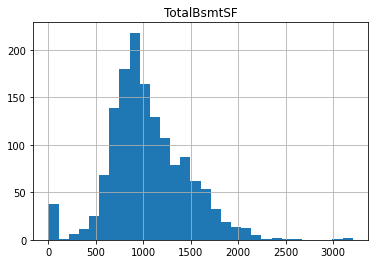

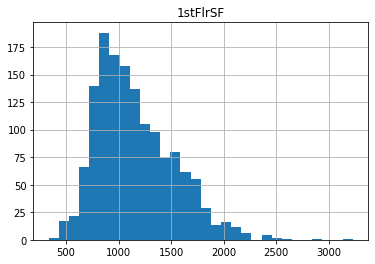

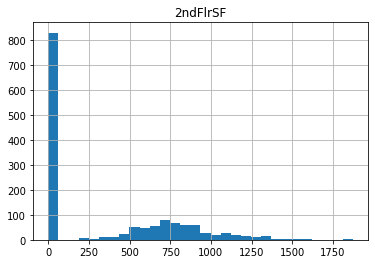

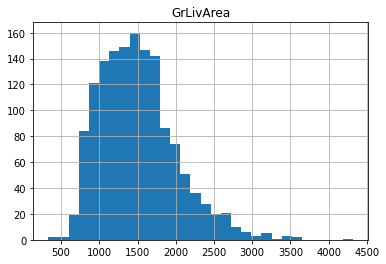

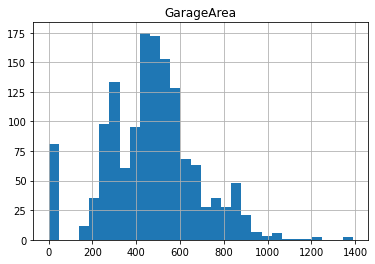

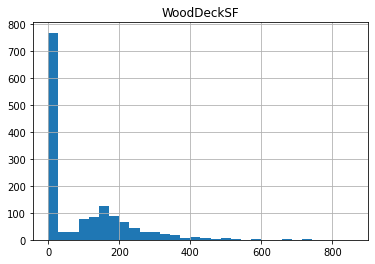

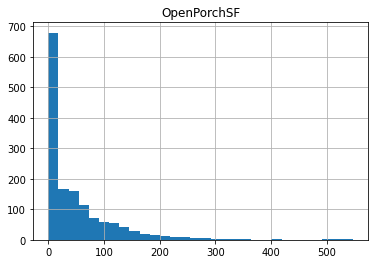

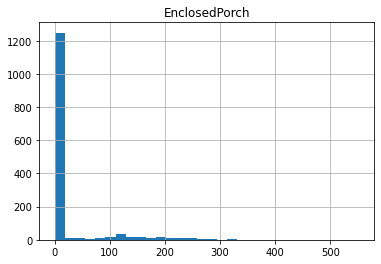

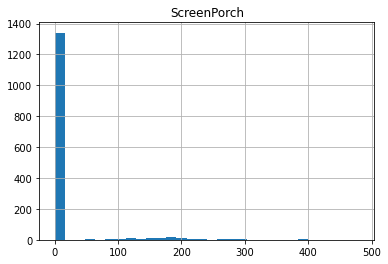

In [22]:
for feature in continuous_variables:
     train_data[feature].hist(bins=30)
     plt.title(feature)
     plt.show()

#### Catagorical Variables

In [25]:
categorical_features=[]
for feature in train_data.columns:
    if train_data[feature].dtype=='O'and feature!= 'SalePrice':
        categorical_features.append(feature)
print(categorical_features)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


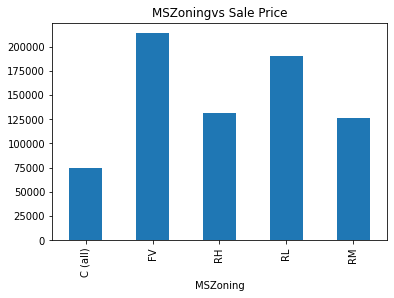

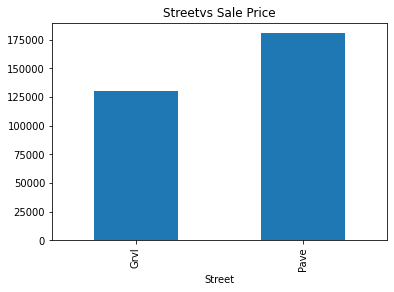

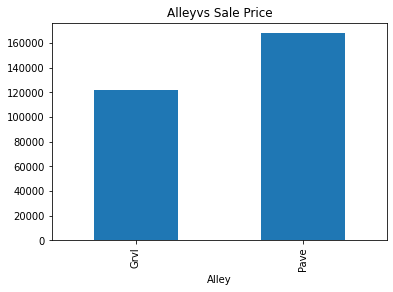

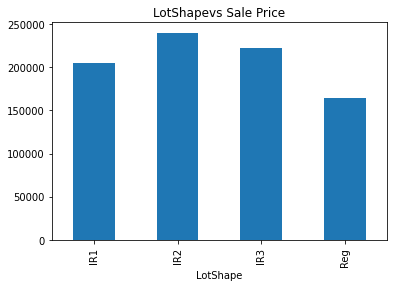

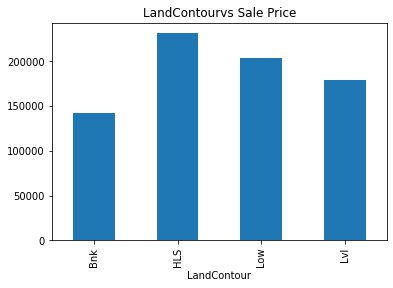

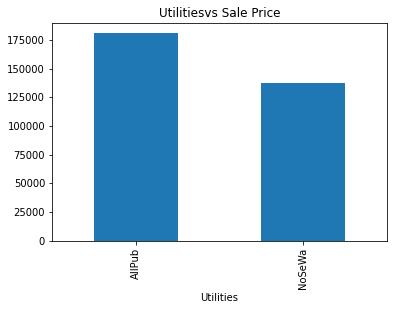

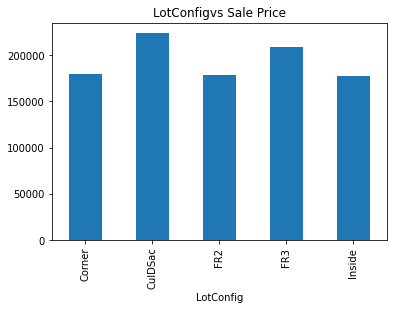

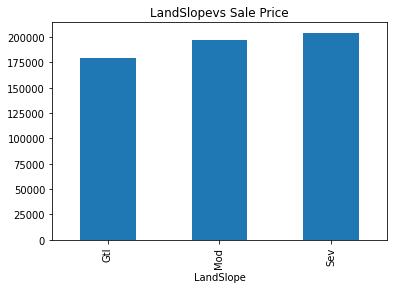

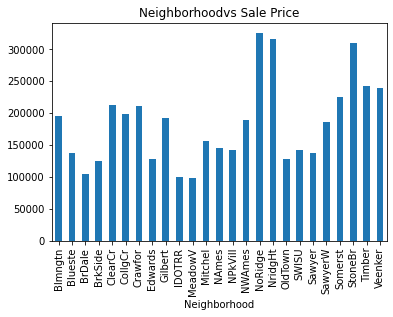

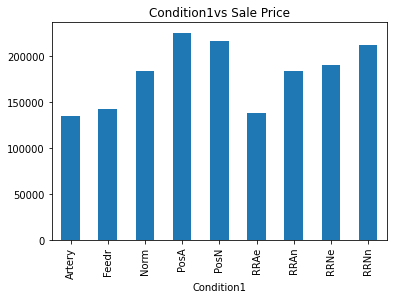

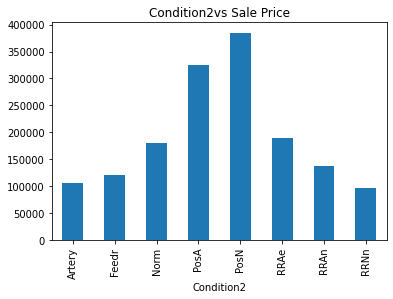

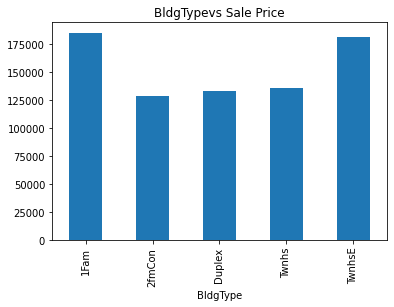

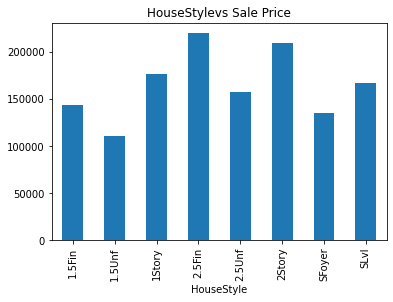

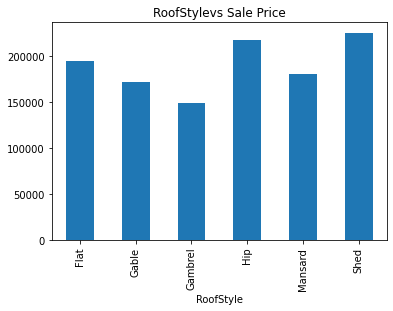

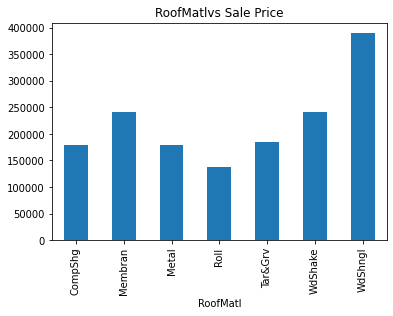

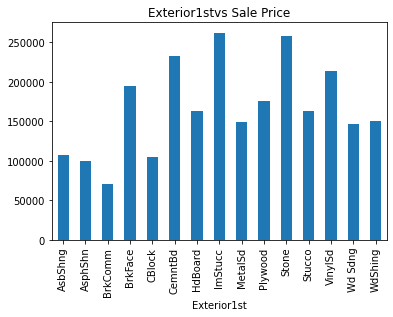

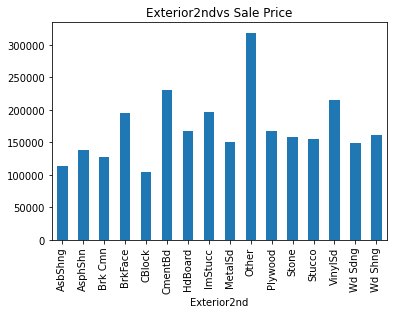

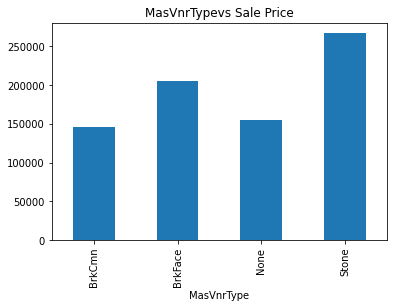

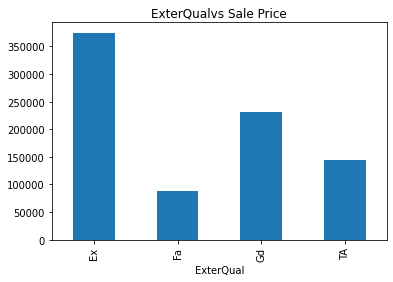

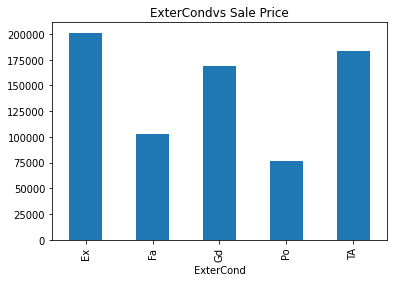

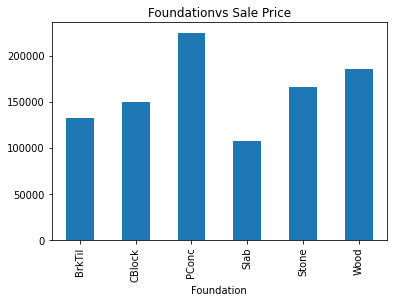

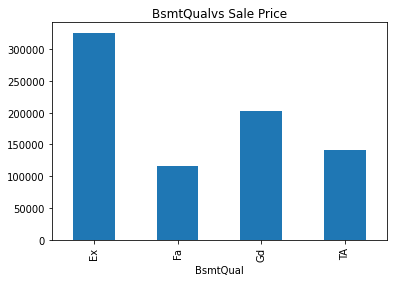

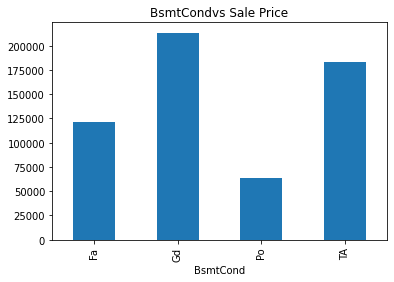

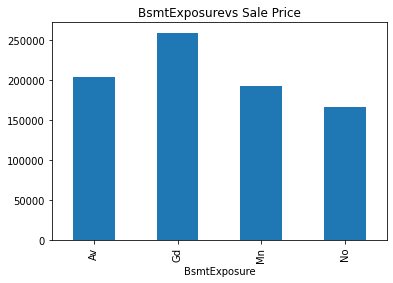

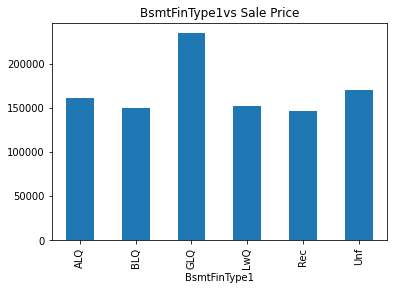

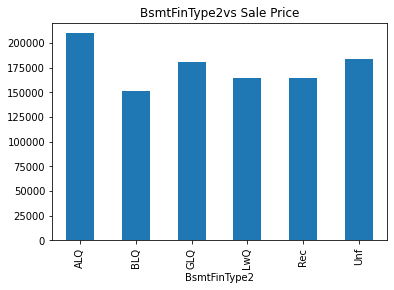

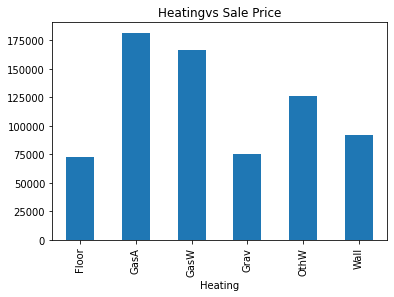

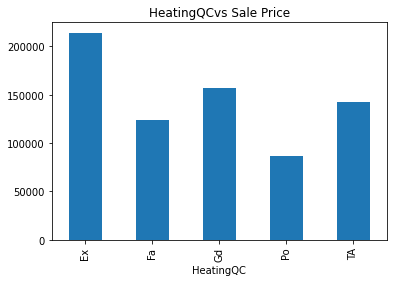

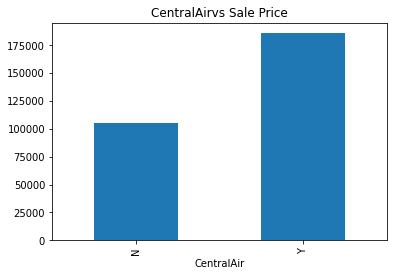

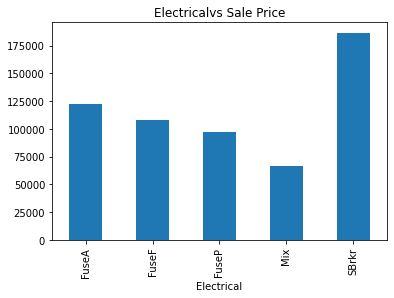

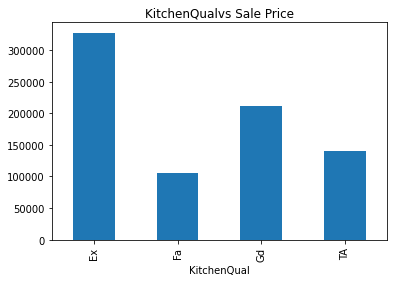

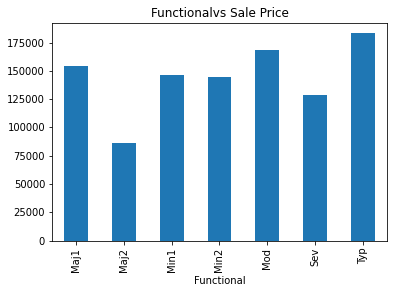

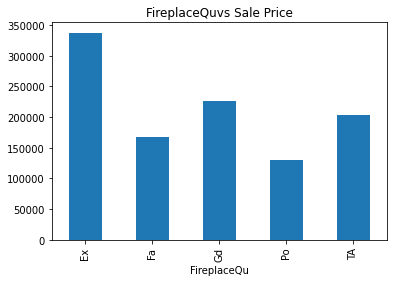

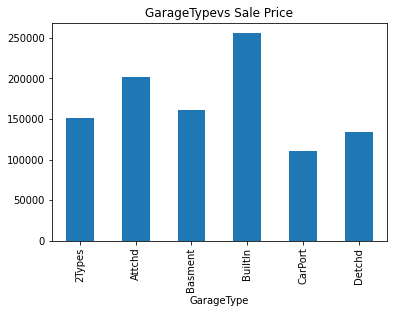

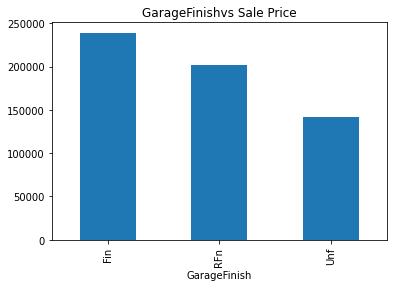

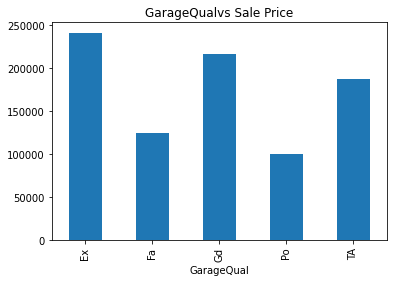

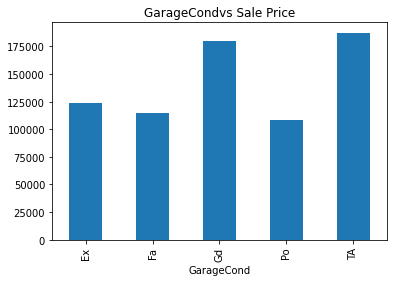

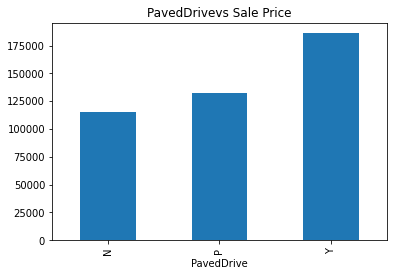

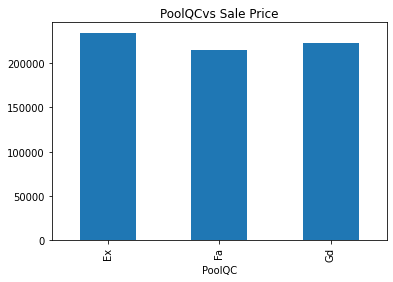

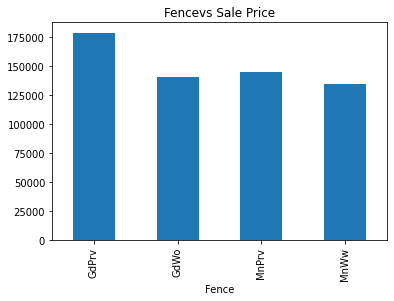

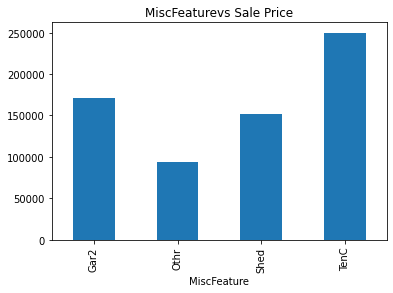

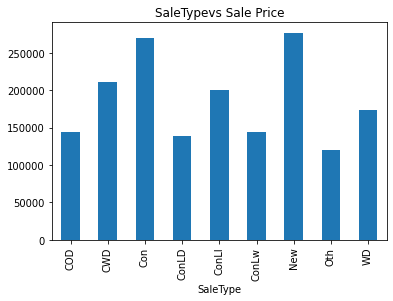

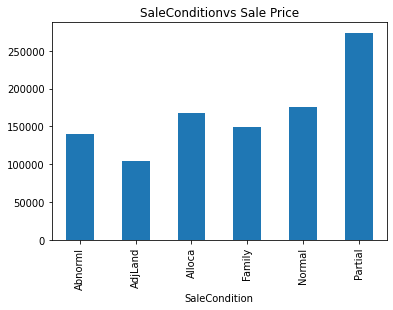

In [26]:
for feature in categorical_features:
    train_data.groupby(feature)['SalePrice'].mean().plot.bar()
    plt.title(feature + 'vs Sale Price')
    plt.show()

#### Ploting the Distribution of the target variable

C:\Users\Govind Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Govind Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

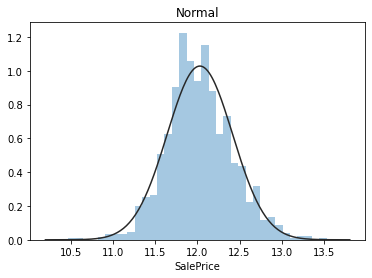

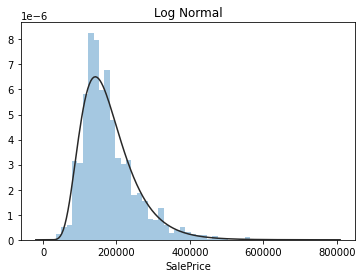

In [66]:
y1 = train_data['SalePrice']
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y1, kde=False, fit=stats.lognorm)

From the above plot we can infer that our distribution does not follow normal distribution, So we have to tranform the target variable. 
Log Tranformation seems like a better fit, hence we apply logorithmic transformation on "SalePrice" column.

In [7]:
#Log Transform
y = np.log(train_data["SalePrice"])

### Data Imputation

#### Catagorical Values:

Since the below features have more NA values, instead of droping the columns we simple impute them with "None" and  "Mode"

In [8]:
features_nonefill = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageQual", "GarageFinish", "GarageType", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
#filling NA with "None"
data[features_nonefill] = data[features_nonefill].fillna("None")

In [9]:
features_modefill = ["MasVnrType", "MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual", "Functional"]
#filling NA with "Mode" i.e Most-frequently occuring
data[features_modefill] = data.groupby("Neighborhood")[features_modefill].transform(lambda x:x.fillna(x.mode()[0])) #grouping by Neighborhood

#### Numeric Values:

Since the below features have more NA values, instead of droping the columns we simple impute them with "median" and  "0"

In [10]:
features_medianfill = ["GarageArea", "LotFrontage"]
#filling NA with "median"
data[features_medianfill] = data.groupby("Neighborhood")[features_medianfill].transform(lambda x: x.fillna(x.median())) #grouping by Neighborhood

In [11]:
features_zerofill = ["GarageYrBlt", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
#filling NA with 0
data[features_zerofill] = data[features_zerofill].fillna(0)

### Feature Engineering

Creating new columns by adding existing columns to get meaningful data

In [12]:
data["TotalArea"] = data["GrLivArea"] + data["TotalBsmtSF"]
data["TotalBaths"] = data["FullBath"] + data["BsmtFullBath"] + 0.5*(data["HalfBath"]+data["BsmtHalfBath"])
data["TotalPorch"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]

### Data Transform & Feature Scaling

#### Data Transformation

By looking at the data we can say that "MSSubClass" and "YrSold" are Catagorical Variables, so we transform them into dtype : object

In [13]:
data[["MSSubClass", "YrSold"]] = data[["MSSubClass", "YrSold"]].astype("category") #converting into catagorical value

"MoSold" is a Cyclic Value. We handle this type of data by mapping each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sine and cosin trigonometric functions.

In [15]:
data["MoSoldsin"] = np.sin(2 * np.pi * data["MoSold"] / 12) #Sine Function
data["MoSoldcos"] = np.cos(2 * np.pi * data["MoSold"] / 12) #Cosine Function
data = data.drop("MoSold", axis=1)

Since our data is positively skewed we apply boxcox normalization and transform the skwed data

In [16]:
skew_Values = data.skew(numeric_only=True).abs()
skew_rows = skew_Values[skew_Values>1].index
for i in skew_rows:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1)) #Normalizing Skewed Data

C:\Users\Govind Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Govind Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\stats.py:3943: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


#### Feature Scaling

We use Robust Scaling because Robust Scaler algorithms scale features that are robust to outliers and mostly work as min-max scaler

In [17]:
cols = data.select_dtypes(np.number).columns
data[cols] = RobustScaler().fit_transform(data[cols])

#### Encoding

In [18]:
data = pd.get_dummies(data) #Get_dummies function to encode data

### Feature Recovery & Removing Outliers

In [19]:
X_train = data.loc[train_data.index] #Training Data-set
X_test = data.loc[test_data.index] #Testing Data-set

To remove outliers, we fit a linear model to the training data and remove examples with a standardized residual greater than 3

In [20]:
residuals = y - LinearRegression().fit(X_train, y).predict(X_train)
outliers = residuals[np.abs(zscore(residuals)) > 3].index

In [21]:
X_train = X_train.drop(outliers)
y = y.drop(outliers)

## Optimization, Training and Testing

### Hyper Parameter Optimization 

In [22]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
scorer = make_scorer(rmse, greater_is_better=False)

We use Randomized Search for Optimization, since it is more efficient.
We define a function which takes in model and parameter grid as inputs , uses Radomized search and returns fit of the model

In [25]:
def random_search(model, grid, n_iter=100):
    if model == xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4):
        searchxg = RandomizedSearchCV(estimator = model, param_distributions = grid, cv=kf, n_iter = n_iter, n_jobs=-1, random_state=0, verbose=True)
        return searchxg.fit(X_train,y,early_stopping_rounds=5,verbose=False)
    else:
        search = RandomizedSearchCV(estimator = model, param_distributions = grid, cv=kf, n_iter = n_iter, n_jobs=-1, random_state=0, verbose=True)
        return search.fit(X_train, y)

In [27]:
xgb_hpg = {'n_estimators': [100, 400, 800],'max_depth': [3, 6, 9],'learning_rate': [0.05, 0.1, 0.20],'min_child_weight': [1, 10, 100]} #XGBoost
ridge_hpg = {"alpha": np.logspace(-1, 2, 500)} #Ridge Regressor
lasso_hpg = {"alpha": np.logspace(-5, -1, 500)} #Lasso Regressor
svr_hpg = {"C": np.arange(1, 100), "gamma": np.linspace(0.00001, 0.001, 50), "epsilon": np.linspace(0.01, 0.1, 50)} #Support Vector Regressor
lgbm_hpg = {"colsample_bytree": np.linspace(0.2, 0.7, 6), "learning_rate": np.logspace(-3, -1, 100)} #LGBM 
gbm_hpm = {"max_features": np.linspace(0.2, 0.7, 6), "learning_rate": np.logspace(-3, -1, 100)}

In [28]:
xgb_search = random_search(xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4),xgb_hpg) #XGBoost
ridge_search = random_search(Ridge(), ridge_hpg) #Ridge Regressor
lasso_search = random_search(Lasso(), lasso_hpg) #Lasso Regressor
svr_search = random_search(SVR(), svr_hpg,n_iter=100) #Support Vector Regressor
lgbm_search = random_search(LGBMRegressor(n_estimators=2000, max_depth=3), lgbm_hpg,n_iter=100) #LGBM
gbm_search = random_search(GradientBoostingRegressor(n_estimators=2000, max_depth=3),gbm_hpm,n_iter=100) #Gradient Boost

C:\Users\Govind Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


### Ensemble Learning Model

We take all the 6 models above, stack them into 1 model and perform Hyper Parameter Tuning

#### Tuning and Fitting

In [31]:
models = [search.best_estimator_ for search in [xgb_search,ridge_search, lasso_search, svr_search, lgbm_search, gbm_search]] #list of best estimators from each model
ensemble_search = random_search(StackingCVRegressor(models, Ridge(), cv=kf), {"meta_regressor__alpha": np.logspace(-3, -2, 500)}, n_iter=20) #Ensemble Stack
models.append(ensemble_search.best_estimator_) #list of best estimators from each model including Stack

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### Predicting Values

In [32]:
prediction = [i.predict(X_test) for i in models] #Np array of Predictions

C:\Users\Govind Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\Govind Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
C:\Users\Govind Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\Govind Krishna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [53]:
p = prediction

### Conversion and Submission

We Convert the predictions into given format, and finally converting them back to normal by unsing exponential function

In [54]:
p.append(np.log(old_prediction.SalePrice)) #appending old predictions

In [59]:
predictions= np.average(p,axis=0) #average of all the values including old prediction

In [67]:
my_prediction = pd.DataFrame({"Id": test_data.index, "SalePrice": np.exp(predictions)}) # given format
my_prediction.to_csv("E:\Education\Kaggle Projects\House Price - Advanced Regression/my_prediction_ensemble.csv", index=False) #Saving to CSV